In [50]:
!pip install jsonlines

In [51]:
import jsonlines
import networkx as nx
import itertools
import random

import matplotlib.pyplot as plt
import numpy as np
import collections

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle

# Part 1: Select data and create network
I will be working with authors as nodes and co-author relationships as edges.

I will be using a random sample of 1000 papers from dblp-ref-1.json. I am choosing this approach because it limits the graph to a reasonable size while eliminating as much bias in the selection process as possible. 

For example, choosing a random sample of 1000 nodes would disproportionately favor lower-degree nodes since those are much more common in the dataset. Choosing a connected subgraph or choosing only papers from a certain venue might artificially centralize certain nodes. Thus, this is the most interesting approach that I came up with.

Change the following PATH to locate the json file:


In [52]:
PATH = '/content/drive/MyDrive/CISC351/dblp-ref/dblp-ref-1.json'
# Seeds ensure consistent random samples across different runs
random.seed(54154851)
np.random.seed(54154851)

Reading the raw data from the json file:

In [53]:
# author_list_list : a list containing all authors of each paper
# author_set       : a set containing all authors
author_list_list = []
author_set = set()

with jsonlines.open(PATH) as reader:
    for obj in reader:
        try:
            author_list_list.append(obj['authors'])
        except:
            pass

author_list_list = random.sample(author_list_list, 1000)
for author_list in author_list_list:
    for author in author_list:
        author_set.add(author)

Creating the network graph:

In [54]:
G = nx.Graph()

# Adds a node for each author in author_set
# Using a set to ensure no duplicates
for author in author_set:
    G.add_node(author)

# Using itertools, enumerates each pair of co-authors and adds that edge to the Graph
for author_list in author_list_list:
    relationships = itertools.combinations(author_list, 2)
    for edge in relationships:
        G.add_edge(edge[0], edge[1], color='r')

# Part 2: Network analysis, reporting basic statistics

Reporting statistics: 

Number of nodes:  2896
Number of edges:  4180
Average degree:  2.886740331491713
Radius and Diameter are infinite because the graph is not connected
Density:  0.0009971469193408335


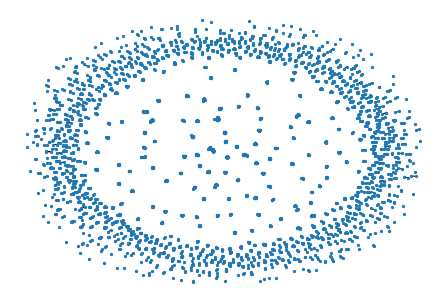

In [55]:
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
average_degree = sum(degree_sequence) / len(degree_sequence)

print("Average degree: ", average_degree)
try:
    eccentricities = nx.algorithms.distance_measures.eccentricity(G)
    print("Radius: ", nx.algorithms.distance_measures.radius(G, eccentricities))
    print("Diameter: ", nx.algorithms.distance_measures.diameter(G, eccentricities))
except nx.exception.NetworkXError as e:
    if str(e) == "Found infinite path length because the graph is not connected":
        print("Radius and Diameter are infinite because the graph is not connected")
print("Density: ", nx.classes.function.density(G))
nx.draw(G, node_size=5, edgelist=G.edges)
plt.draw()

Basic statistics:

*   Number of nodes: 2896
*   Number of edges: 4180
*   Average degree: 2.887
*   Graph is not connected so radius and diameter are infinite
*   Density: 0.0009971



Generating a histogram: 

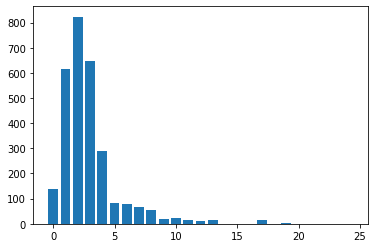

In [56]:
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.bar(deg, cnt)
plt.show()

The average degree and density show that the graph is relatively sparse, which is expected since it's impossible for a human to write more than a certain number of scholarly papers in his/her lifetime (and thus it's impossible to co-author with more than a certain number of people). 

The most common degree is 2, which is shown on the histogram. There are also some nodes with no edges, which indicates that some authors in the dataset have not collaborated. 

We can also see that very few authors have collaborated with 10 or more others. This is expected, since it takes a lot of time and effort to publish a paper and many authors might not have even published that many papers. 

# Part 3: Node centrality analysis

In [57]:
degree = nx.algorithms.centrality.degree_centrality(G)
print(sorted(degree, key=degree.get, reverse=True)[0:3])
load = nx.algorithms.centrality.load_centrality(G, cutoff=5)
print(sorted(load, key=load.get, reverse=True)[0:3])
betweenness = nx.algorithms.centrality.betweenness_centrality(G)
print(sorted(betweenness, key=betweenness.get, reverse=True)[0:3])

['Rui Zhang', 'Zhaowen Wang', 'Xiaokang Yang']
['Rui Zhang', 'Huei Peng', 'Jessy W. Grizzle']
['Rui Zhang', 'Huei Peng', 'Jessy W. Grizzle']


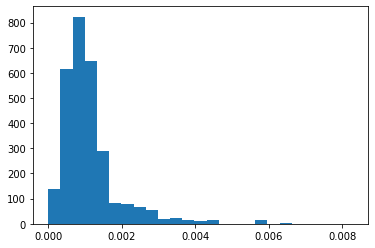

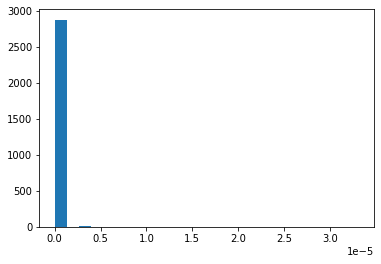

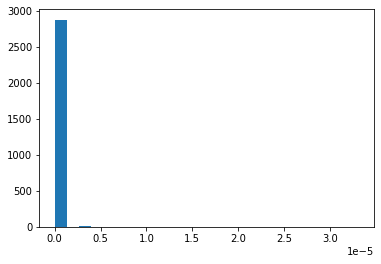

In [58]:
for measure in [degree, load, betweenness]:
    sequence = sorted([measure[n] for n in measure], reverse=True)
    plt.hist(sequence, bins=25)
    plt.show()

The most central nodes in each measure are shown above. The most central node, Rui Zhang, is common in all measures. Interestingly, the second and third most central nodes for degree centrality are different than for the other measures. This indicates that even though Xiaokang Yang has collaborated with more authors, Huei Peng's collaborators are more important in the network.

The degree centrality shows the same distribution as the graph's degrees. This is expected since degree centrality is based directly on degree.

The distribution of the other two centralities indicate that the majority of all nodes are very non-central, with a few that are more central than the rest. This indicates that a small group of nodes acts like a 'hub' which connects other disconnected nodes. 

Since the graph is so disconnected, it's expected that centrality measures are so low for all nodes. 

# Part 4: Link prediction

The following methods are taken from the link https://github.com/lucashu1/link-prediction/blob/master/link-prediction-baselines.ipynb (given in the assignment) and its dependancies. The dependancy ```gae``` was written for Python 2.7, so the methods here are updated for Python 3.7. 

In [59]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_matrix(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false

def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

Training/Testing split:

In [60]:
adj = nx.to_scipy_sparse_matrix(G)
adj_sparse = nx.to_scipy_sparse_matrix(G)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

**Adamic-Adar**

In [61]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Adamic-Adar Test ROC score: ', str(aa_roc))
print('Adamic-Adar Test AP score: ', str(aa_ap))

Adamic-Adar Test ROC score:  0.9964114832535885
Adamic-Adar Test AP score:  0.9964114832535883


**Node2vec**

The following class and methods are adapted from the node2vec source code given here: https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py. I had difficulties importing the module, so I copied the necessary methods from the source.

In [62]:
class n2v_Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print('Walk iteration:')
		for walk_iter in range(num_walks):
			print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return

def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

from gensim.models import Word2Vec

# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [63]:
# Preprocessing, generate walks
g_n2v = n2v_Graph(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [list(map(str, walk)) for walk in walks]

# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [64]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

print('node2vec Validation ROC score: ', str(val_roc))
print('node2vec Validation AP score: ', str(val_ap))
print('node2vec Test ROC score: ', str(test_roc))
print('node2vec Test AP score: ', str(test_ap))

node2vec Validation ROC score:  0.9398823287012659
node2vec Validation AP score:  0.9573987343561774
node2vec Test ROC score:  0.9545569011698452
node2vec Test AP score:  0.9670322991552138


**Measures considered:**

ROC-AUC (area under the receiver operating characteristic curve) - classification based evaluation measure

AP (average precision score) - ranking based evaluation measure

**Adamic-Adar index (unsupervised method):**

* ROC of 0.9964
* Average precision of 0.9964

**Node2vec (supervised method):**

* Validation ROC of 0.9399
* Validation AP of 0.9574
* Testing ROC of 0.9546
* Testing AP of 0.9670

Both methods performed very well, but using the Adamic-Adar index was both faster and more accurate than the node2vec approach. Since node2vec employs random walks, it might be less suitable for use with a disconnected, sparse graph like the one I have.